# Identifying tetris blocks with a graph convolutional neural network


In this excercise, we will build and train a graph neural network to identify tetris blocks from the graph formed by their mesh:

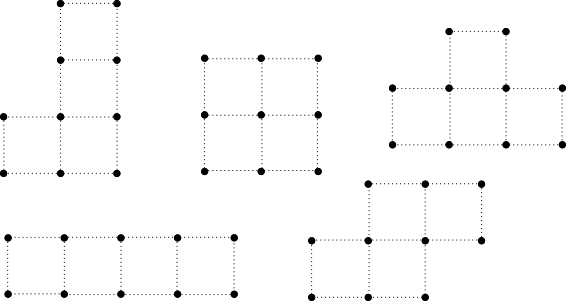

In [153]:
from typing import List, Callable, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Creating the dataset

First, we define the 2d positions of the nodes of the mesh. In the GNN, this information will not be available, but only the connections between the nodes.

In [154]:
lblock = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [1.,2.], [2.,2.], [1.,3.], [2.,3.]])
square = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [0.,2.], [1.,2.], [2.,2.]])
line = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [3.,0.], [4.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [4.,1.]])
step = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [1.,2.], [2.,2.], [3.,2.]])
tblock = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [3.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [1.,2.], [2.,2.]])
tetris_blocks = [lblock, square, line, step, tblock]

Next, we need to compute the edges of the mesh. Every pair of points that has a distance less or equal to a given cutoff (default: 1) shall be connected.

---

**Task:** Complete the function ``compute_edges`` so that it returns a list of edges for the passed tensor of points. You can check your solution in the cell below, which creates the dataset and plots the tetris blocks. Note, that according to this definition self-connections $(i,i)$ should be included.

In [155]:
def compute_edges(points:torch.FloatTensor, cutoff:float=1.) -> torch.LongTensor:
    """
    This function computes the edges of graph given an array of nodes with 2d coordinates.
    The graph will we created by connecting all nodes with an euclidean distance smaller or equal
    than the provided cutoff.

    Args:
    - points: tensor of coordinates with shape (num_nodes x 2)
    - cutoff: cutoff distance to determine whether two points are connected in the graph.

    Returns:
    - edges: tensor of shape [num_edges x 2] where each row corresponds to the indices of the 
      connected nodes (incoming, outgoing)

    """
    ## INSERT YOUR SOLUTION HERE ##
    l2_matrix = ((points.reshape(points.shape[0],1,points.shape[1]) - points.reshape(1,points.shape[0],points.shape[1]))**2).sum(dim = -1)
    return (l2_matrix <= cutoff).nonzero()

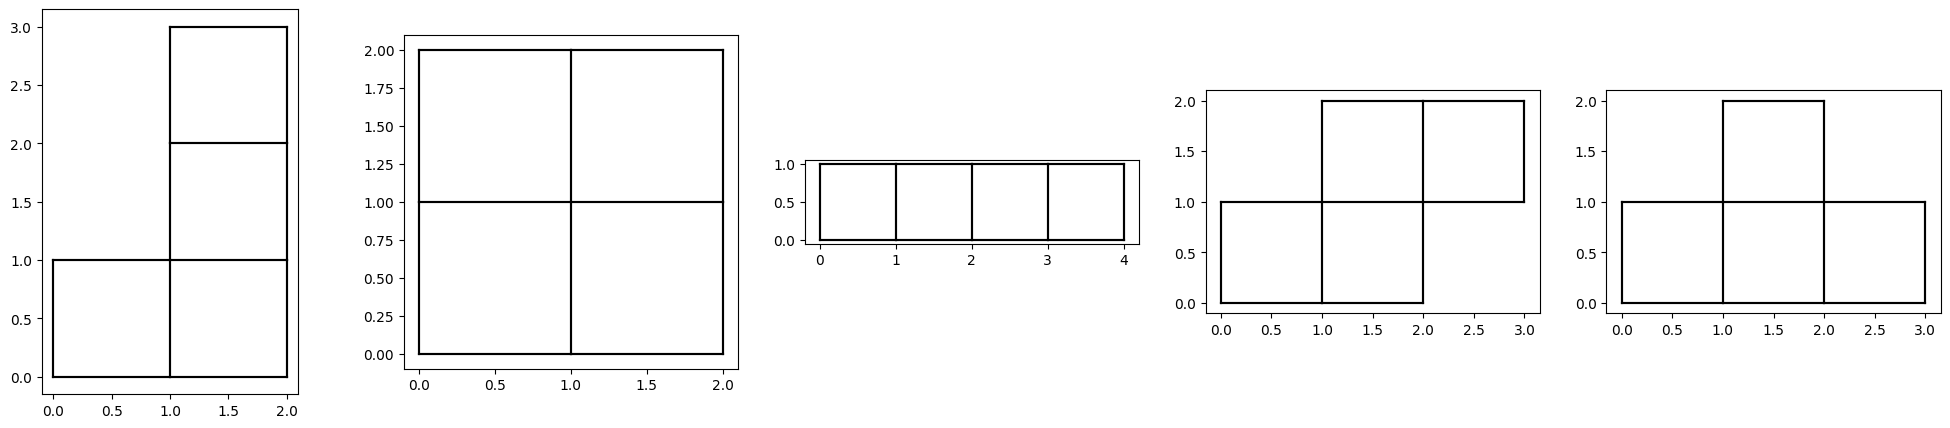

In [156]:
def create_dataset(shuffle:bool=False):
    tetris_edges = []
    tetris_points = []
    for points in tetris_blocks:
        if shuffle:
            sort_idx = torch.randperm(points.shape[0])
            points = points[sort_idx]
        tetris_points.append(points)

        edges = compute_edges(points)
        tetris_edges.append(edges)
    return tetris_points, tetris_edges

tetris_points, tetris_edges = create_dataset(shuffle=False)

plt.figure(figsize=(25, 5))
for i, graph in enumerate(zip(tetris_points, tetris_edges)):
    block, edges = graph
    plt.subplot(1, 5, i+1)
    X = torch.vstack([block[edges[:,0],0], block[edges[:,1], 0]])
    Y = torch.vstack([block[edges[:,0],1], block[edges[:,1], 1]])
    plt.plot(X, Y, c='k')
    plt.gca().set_aspect('equal')

plt.show()

Finally, a batched version of the dataset is created. Since the graphs have different numbers of nodes and edges, we can not use a separate batch dimension. Instead, we need to use a global, sparse representation where nodes of different graphs have unique indices. 

We describe the graph with the following tensors:
- ``batched_node_labels``: The node labels are the main input to the graph network and have a shape (num_nodes, 1). Since we don't have different types of noes, we just label every node `1`.
- ``batched_edges``: The edges, you have computed in your first task, are stacked and indices are converted to be compatible with the ``batched_node_labels``. E.g. for two graphs with 3 and 5 nodes, respectively, the node indices will be 0-2 for the first and 3-7 for the second graph.
- ``graph_idx``: Since we do not have an explicit batch dimension, we need to store here to which graph a node belongs.
- ``classes``: The labels for classification. Since we aim to identify each tetris block, we use here the indices 0-4.

In [157]:
def build_batch(edges_list:List[torch.Tensor]) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    num_nodes = torch.tensor([torch.max(edges)+1 for edges in edges_list])
    classes = torch.arange(len(tetris_edges), dtype=torch.long)
    block_idx = torch.repeat_interleave(classes, num_nodes)

    # convert node indices to global batch indices
    node_offsets = torch.cumsum(torch.cat([torch.zeros((1,), dtype=torch.long), num_nodes]), 0)
    global_edges_list = [edges + node_offsets[i] for i, edges in enumerate(edges_list)]
    batched_node_labels = torch.ones((torch.sum(num_nodes), 1))
    batched_edges = torch.vstack(global_edges_list)
    return batched_node_labels, batched_edges, block_idx, classes
    
batch = build_batch(tetris_edges)

print(f'batched_node_labels [first 10 entrie]: {batch[0][:10]}')
print(f'batched_edges [first 10 entrie]: {batch[1][:10]}')
print(f'block_idx: {batch[2]}')
print(f'classes: {batch[3]}')

batched_node_labels [first 10 entrie]: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
batched_edges [first 10 entrie]: tensor([[0, 0],
        [0, 1],
        [0, 3],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 4],
        [2, 1],
        [2, 2],
        [2, 5]])
block_idx: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4])
classes: tensor([0, 1, 2, 3, 4])


## Graph Convolutional Neural Network

In this section we will implement the GNN and its required layers and ops.

First, we will implement a function that sums over nodes and edges of a graph. The operation we need is called `scatter_add`, which takes an input tensor `x` and an index tensor `idx`:

\begin{align}
\text{out}_i = \sum_j x_j \mathbb{1}_{\text{idx}_j=i}
\end{align}

`Scatter_add` is visualized by the following picture:

![scatter_add](https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true)

---

**Task:** Implement ``scatter_add`` below. You can use the PyTorch library function [``index_add``](https://pytorch.org/docs/stable/generated/torch.Tensor.index_add_.html#torch.Tensor.index_add_) for that.

In [158]:
def scatter_add(
    x: torch.Tensor, idx: torch.Tensor, dim_size: int, dim: int = 0
) -> torch.Tensor:
    """
    Sum over given indices as described above.

    Args:
    - x: input tensor
    - idx: index tensor
    - dim: dimension along which is summed
    - dim_size: size of the dimension along which is summed in the output tensor

    Returns:
    - summed_x: tensor with shape: x.shape[:dim] + (dim_size,) + x.shape[dim+1:]
    """
    ## INSERT YOUR SOLUTION HERE
    z = torch.zeros( (x.shape[:dim] + (dim_size,) + x.shape[dim+1:]), dtype = x.dtype)
    return z.index_add(dim, idx, x)
    
    
# Test
x = torch.tensor(([1,2,3,4], [3,2,4,6]))
idx = torch.tensor([0, 0, 1, 0])

y = scatter_add(x, idx, dim_size=2, dim=1)
print("Result:", y)
print("Expected:", torch.tensor([[ 7,  3], [11,  4]]))

Result: tensor([[ 7,  3],
        [11,  4]])
Expected: tensor([[ 7,  3],
        [11,  4]])


Finally, we are ready to implement the graph convolution layer. We will use the approximate GCN by Kipf & Welling which we derived in the lecture.

Renormalized Laplacian:
\begin{align*}
    &\textbf{I} + \textbf{D}^{-\frac{1}{2}} \textbf{A} \textbf{D}^{-\frac{1}{2}} \rightarrow \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} 
    \\
    \text{with } & \mathbf{\tilde{A}} = \mathbf{A} + I_N, \quad \tilde{D}_{ii} = \sum_j \tilde{A}_{ij}
\end{align*}

Graph convolution:
\begin{align*}
    g_\theta * x &= \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} x \Theta,
\end{align*}

Since we use a sparse representation of the graph, you can not apply this directly. Instead, the formula has to be evaluated for the given edge indices. We will us the message passing paradigm to separate the graph convolution into message function

\begin{align*}
\mathbf{M}_t(\mathbf{x}_i^t, \mathbf{x}_j^t) &= (\mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}})_{ij} \textbf{x}_j,
\end{align*}

aggregation

\begin{align*}
m_i = \sum_{(i,j) \in E} \mathbf{M}_t(\mathbf{x}_i^t, \mathbf{x}_j^t)
\end{align*}

and update function

\begin{align*}
\textbf{U}_t(\mathbf{x}_i^t, \mathbf{m}_i^{t+1}) &= \text{ReLU}(\mathbf{m}_i \Theta).
\end{align*}

---

**Task:** Complete the GraphConv class below by implementing the three functions.

***Hints:***
- The edges for the tetris blocks, as extracted above, should already contain self-connections. Therefore, it is not necessary here to add them, which corresponds to adjusting the adjacency matrix with $\mathbf{\tilde{A}} = \mathbf{A} + I_N$.
- Use the `scatter_add` function from above.


In [165]:
class GraphConv(nn.Module):

    def __init__(self, n_in:int , n_out: int, activation=F.relu):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.activation = activation

        self.theta = nn.Parameter(torch.empty((n_in, n_out)))
        torch.nn.init.xavier_uniform_(self.theta)


    def forward(self, x:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        messages = self.compute_message(x, edges)

        # aggregate messages for each node
        aggregated_messages = self.aggregate(messages, edges)

        # update node states
        x = self.compute_update(x, aggregated_messages)
        return x

    def aggregate(self, messages:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE
        return scatter_add(messages, edges[:,1], torch.max(edges) + 1, dim = 0)


    def compute_message(self, x:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE
        n_nodes = (torch.max(edges) +1).item()
        a_mat = torch.zeros((n_nodes,n_nodes))
        a_mat[edges[:,0],edges[:,1]] = 1
        d_mat = torch.diag(1/torch.sqrt(a_mat.sum(dim = 1)))
        l_mat = d_mat @ a_mat @ d_mat
        return x[edges[:,1]]  * l_mat[edges[:,0],edges[:,1]].reshape(-1,1)

    def compute_update(self, x:torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE
        return self.activation(m @ self.theta)

Here is an example network that uses the GraphConv, you have just implemented. Feel free to experiment with the number of conv layers, hidden features, output layers, etc.

In [166]:
class GCN(nn.Module):
    def __init__(self, n_classes: int = 5, n_hidden:int=20):
        super().__init__()
        self.conv1 = GraphConv(1, n_hidden)
        self.conv2 = GraphConv(n_hidden, n_hidden)
        self.conv3 = GraphConv(n_hidden, n_hidden)
        self.conv4 = GraphConv(n_hidden, n_hidden)
        self.outlayer1 = nn.Linear(n_hidden, n_hidden)
        self.outlayer2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x:torch.Tensor, edges:torch.LongTensor, graph_idx:torch.LongTensor):
        # apply graph convs
        x = self.conv1(x, edges)
        x = self.conv2(x, edges)
        x = self.conv3(x, edges)
        x = self.conv4(x, edges)

        # aggregate nodes by addition
        num_graphs = torch.max(graph_idx) + 1
        x = scatter_add(x, graph_idx, num_graphs)

        # class output
        x = F.relu(self.outlayer1(x))
        x = self.outlayer2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

Here is some code to train your network. With the given network above, it should converge to the correct solution within about 15k steps.

In [167]:
# initialize network
gcn = GCN()

In [168]:
# initialize optimizer
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3)

In [169]:
#perform training
num_steps = 15000
batch = build_batch(tetris_edges)

x, edges, graph_idx, target = batch
for step in range(num_steps):
    optimizer.zero_grad()

    pred = gcn(x, edges, graph_idx)
    loss = F.nll_loss(pred, target)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}: loss={loss}, prediction={pred.argmax(dim=1)}, target={target}")

Step 0: loss=1.620815634727478, prediction=tensor([0, 0, 0, 0, 0]), target=tensor([0, 1, 2, 3, 4])
Step 1000: loss=1.219828486442566, prediction=tensor([3, 1, 3, 3, 3]), target=tensor([0, 1, 2, 3, 4])
Step 2000: loss=1.0857375860214233, prediction=tensor([0, 1, 2, 3, 3]), target=tensor([0, 1, 2, 3, 4])
Step 3000: loss=1.0124207735061646, prediction=tensor([2, 1, 2, 3, 3]), target=tensor([0, 1, 2, 3, 4])
Step 4000: loss=0.9542832374572754, prediction=tensor([2, 1, 2, 3, 3]), target=tensor([0, 1, 2, 3, 4])
Step 5000: loss=0.9056061506271362, prediction=tensor([2, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 6000: loss=0.8787657022476196, prediction=tensor([4, 1, 2, 3, 3]), target=tensor([0, 1, 2, 3, 4])
Step 7000: loss=0.8277880549430847, prediction=tensor([2, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 8000: loss=0.7958016395568848, prediction=tensor([2, 1, 2, 3, 4]), target=tensor([0, 1, 2, 3, 4])
Step 9000: loss=0.7671784162521362, prediction=tensor([2, 1, 2, 3, 4]), target

## Verify permutation invariance of edges

If everything has been done correctly, your network is invariant to the indexing of the tetris block nodes and edges, as long as the same (i.e. isomorph) graph is described. The following code creates permuted graphs, by shuffling the points of the tetris blocks. It should still give the same answer as above, no matter whether the network is trained or not.



In [170]:
shuffled_points, shuffled_edges = create_dataset(shuffle=True)
shuffled_batch = build_batch(shuffled_edges)
x, edges, graph_idx, target = shuffled_batch

output = gcn(x, edges, graph_idx)
pred = output.argmax(dim=1)
print(f"Prediction with shuffeld nodes: {pred}")

Prediction with shuffeld nodes: tensor([0, 1, 2, 3, 4])
